In [1]:
from inference_utils import *
import numpy as np
import matplotlib.pyplot as plt
import io
from matplotlib.pyplot import figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from PIL import Image
import xml.etree.ElementTree as ET
from PIL import Image

In [2]:
def getBBox(annotation_dir, img_id):
    xml_filePath = os.path.join (annotation_dir, img_id + '.xml')
    xml_file = open(xml_filePath, encoding='UTF-8')
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    for obj in root.iter('object'):
        cls = obj.find('name').text
        if cls != 'HUMAN':
            xmlbox = obj.find('bndbox')
            xmin = int(xmlbox.find('xmin').text)
            xmax = int(xmlbox.find('xmax').text)
            ymin = int(xmlbox.find('ymin').text)
            ymax = int(xmlbox.find('ymax').text)
            single_box = {
                    'xmin':xmin,
                    'xmax':xmax,
                    'ymin':ymin,
                    'ymax':ymax,
            }
            bboxes.append(single_box)
    return bboxes

In [3]:
def normalize_tensor(vector):

    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        vector -= min_v
        vector = vector / range_v
    else:
        vector = torch.zeros(vector.size())

    return vector

In [4]:
def renderFeatureMap(pxl_lvl_anom_score,sample_img):
    score_range = pxl_lvl_anom_score.min(), pxl_lvl_anom_score.max()
    fmap_img = pred_to_img(pxl_lvl_anom_score, score_range)
    
    figure(figsize=(10, 10), dpi=200)
    plt.imshow(sample_img)
    plt.imshow(fmap_img, cmap="jet", alpha=0.5)
    plt.axis('off');
    
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    overlay_img = Image.open(buf)
    plt.clf()
    return np.array(overlay_img), fmap_img

                

In [5]:
def add_bounding_boxes(img_id, sample_img, annotation_dir):
    all_boxes = getBBox(annotation_dir, img_id)
    for bb in all_boxes:
        image = cv2.rectangle(sample_img, (bb['xmin'], bb['ymin']), (bb['xmax'], bb['ymax']), (255, 255, 255), 5)
    return image

In [6]:
def get_all_fv_imgs(img_id, runs_dir, obj_dir, annotation_dir):
    img_id = random.choice(os.listdir(runs_dir))
    run_path = os.path.join(runs_dir, img_id)

    sample_img_path = os.path.join(obj_dir, img_id + '.jpg')
    sample_img = cv2.imread(sample_img_path)
    sample_img = add_bounding_boxes(img_id, sample_img, annotation_dir)
    
    all_vis_imgs = []
    pixels_information = []
    all_fv_imgs = []
    for json_file_name in os.listdir(run_path):
        if '.json' in json_file_name:
            json_file_path = os.path.join(run_path, json_file_name)

            with open(json_file_path) as json_file: result_data = json.load(json_file)
            
            vis_img, fv_img = renderFeatureMap(torch.tensor(result_data['pixel_score']), sample_img)
            
            all_vis_imgs.append(vis_img)
            pixels_information.append(result_data['count_pixels'])
            all_fv_imgs.append(fv_img)
            
    return all_vis_imgs, pixels_information, all_fv_imgs, sample_img


In [7]:
import cv2
runs_dir = '/Users/rc/Documents/GitHub/my_patchcore/FinalCore/exp/2022_07_21_13_18_01/runs'
obj_dir = '/Users/rc/Documents/GitHub/my_patchcore/datasets/full_body/test/objs'
annotation_dir = '/Users/rc/Documents/GitHub/my_patchcore/datasets/full_body/Annotations'

img_id = random.choice(os.listdir(runs_dir))
all_vis_imgs, pixels_information, all_fv_imgs, sample_img = get_all_fv_imgs(img_id, runs_dir, obj_dir, annotation_dir)

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

In [8]:
# import cv2
# runs_dir = '/media/rc/backup/exp/2022_07_21_21_02_52/runs'
# obj_dir = '../datasets/full_body/test/objs/'
# annotation_dir = '../datasets/full_body/Annotations'
# img_id = random.choice(os.listdir(runs_dir))
# all_vis_imgs, pixels_information, all_fv_imgs, sample_img = get_all_fv_imgs(img_id, runs_dir, obj_dir, annotation_dir)

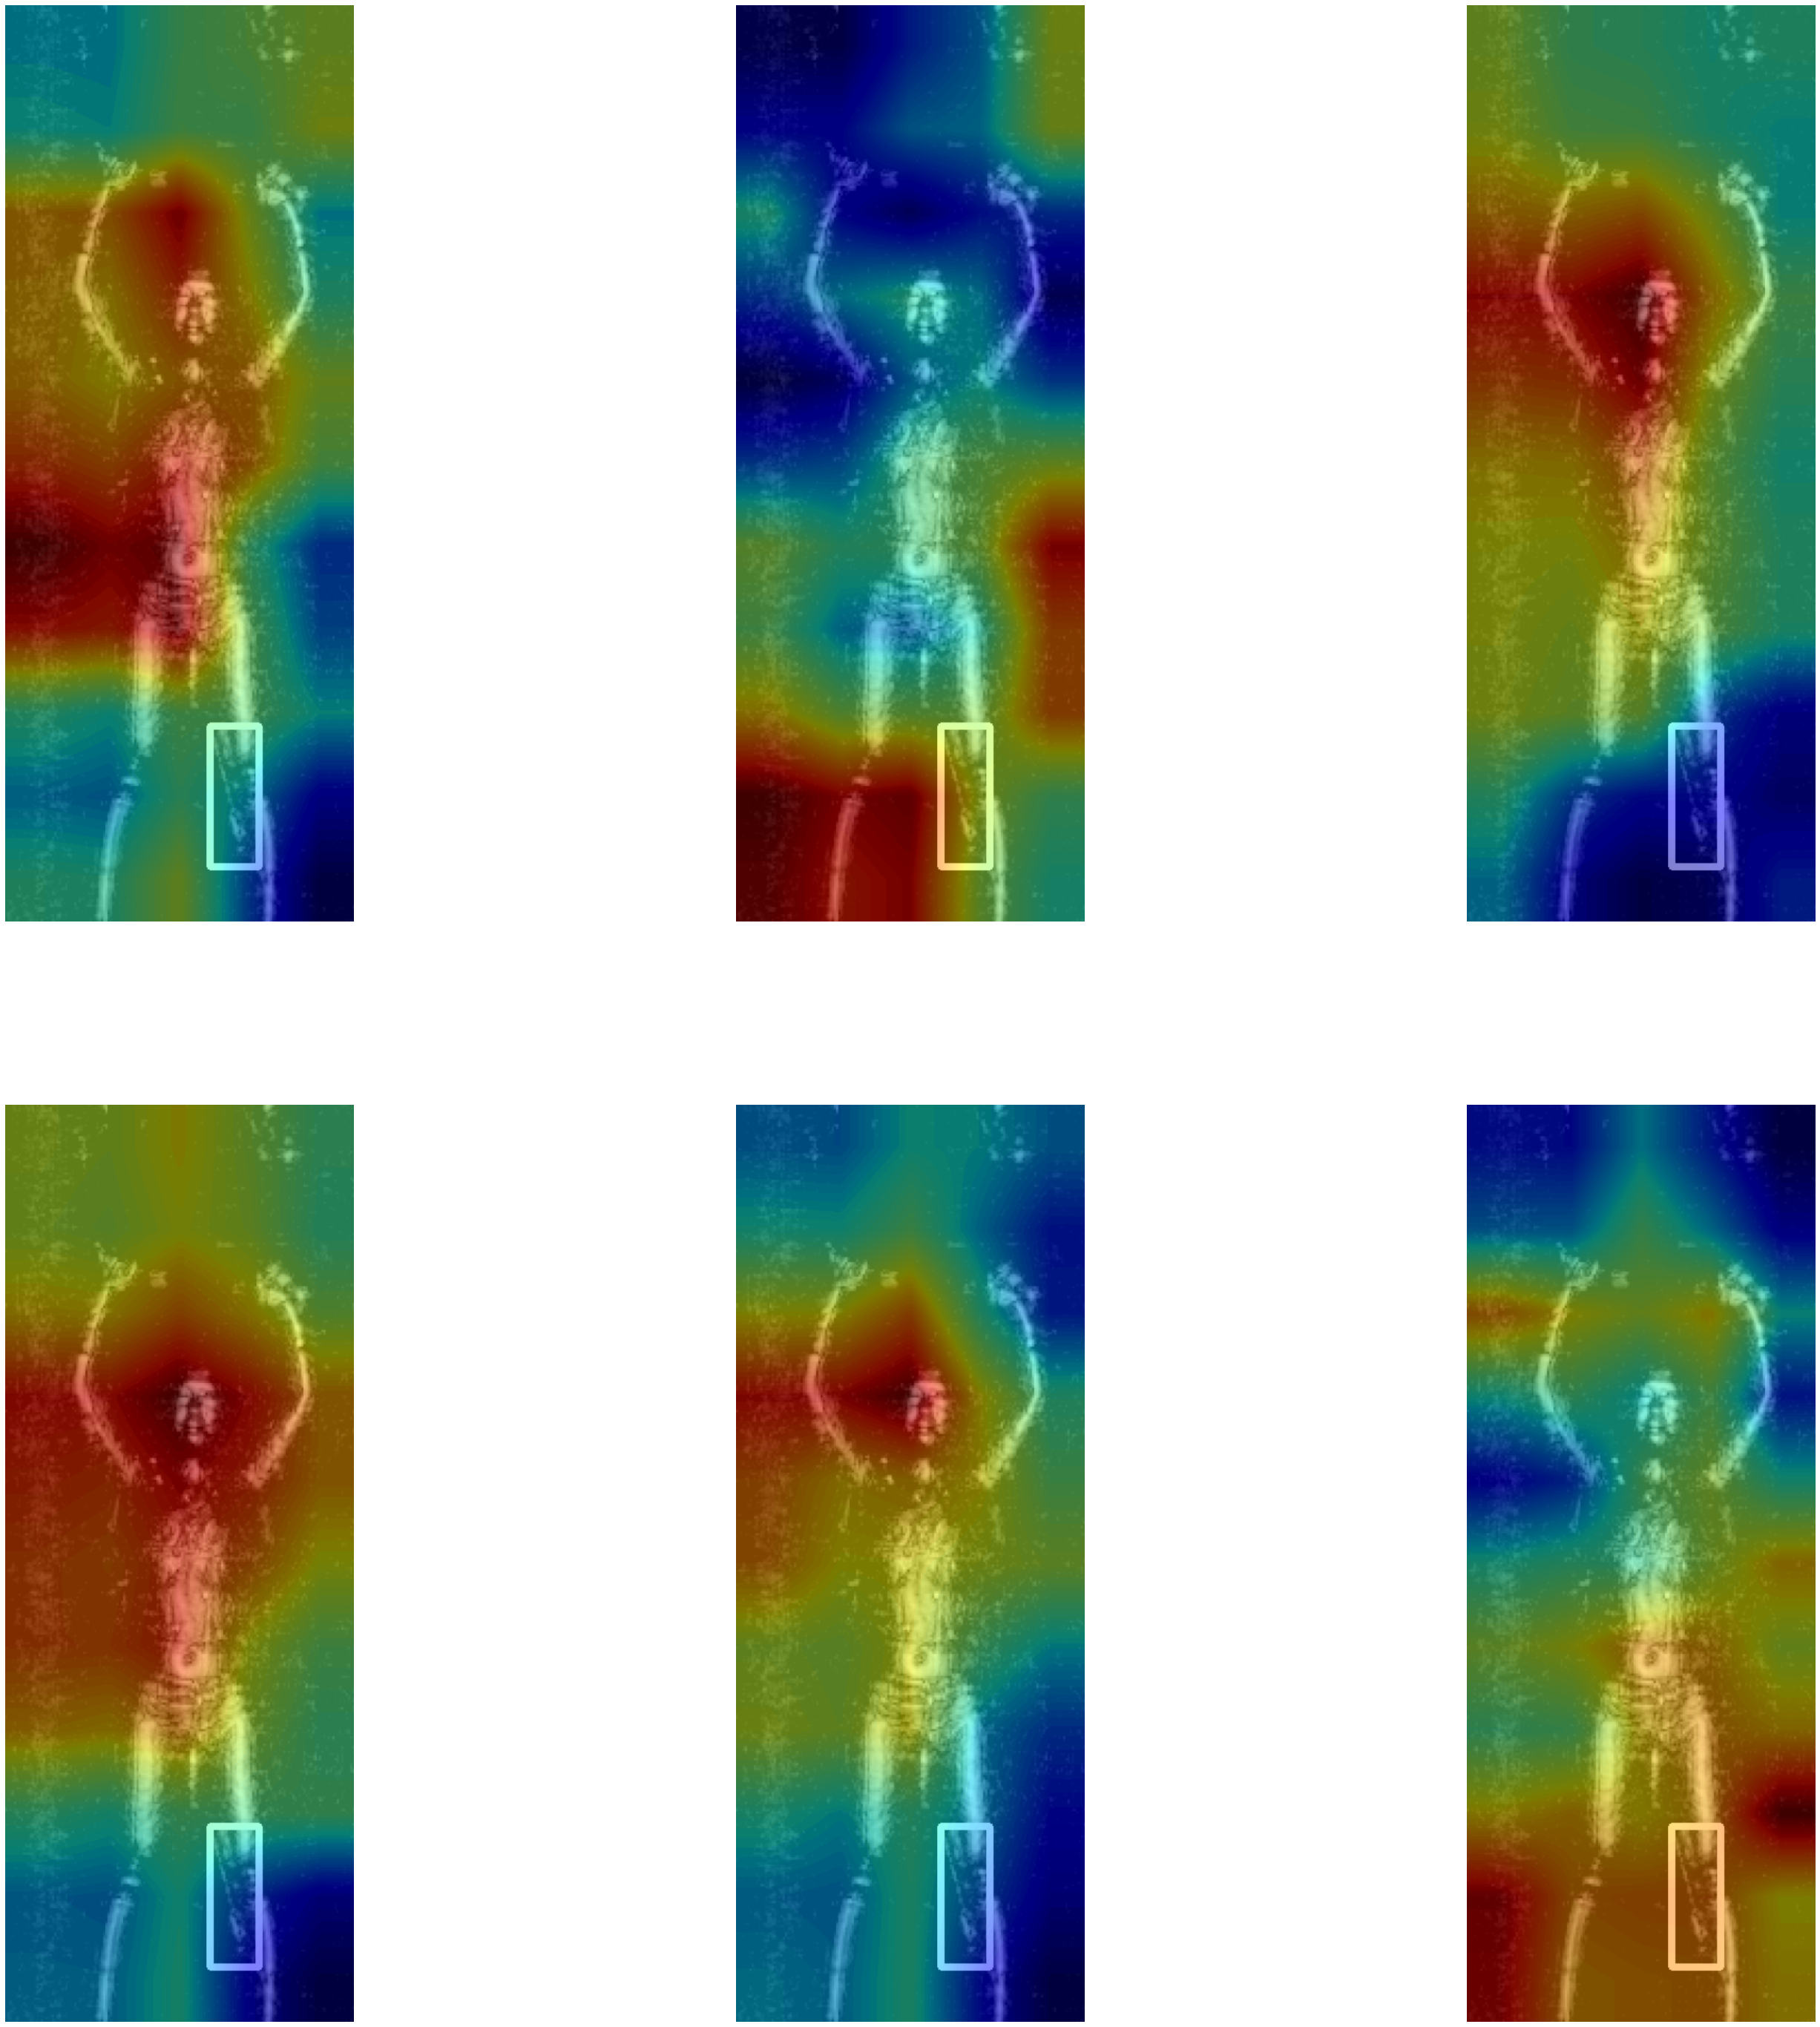

In [9]:
# setting values to rows and column variables
rows = 2
columns = 3
fig = plt.figure(figsize=(50, 50))
for idx, img in enumerate(all_vis_imgs[0:6]):
    fig.add_subplot(rows, columns, idx+1)
    # showing image
    plt.imshow(img)
    plt.axis('off')
#     info =''
#     for th in ['0.85', '0.8', '0.75', '0.7', '0.65']:
#         info += 'higher than {}: {}\n'.format(th,information[idx][th])
#     plt.title(info)

In [10]:
def get_sum_counts(pixels_information):
    sum_list = []
    for fv_info in pixels_information:
        sum_count = 0
        for k in fv_info:
            sum_count += fv_info[k]
        sum_list.append(sum_count)
    return sum_list

In [11]:
import statistics

def get_median_val(inputlist):    
    return statistics.median(inputlist)

def get_min_index(inputlist):
    min_value = min(inputlist)
    min_index=inputlist.index(min_value)
    return min_value, min_index


def assign_weights(rank_list):
    min_value, min_index = get_min_index(rank_list)
    median_val = get_median_val(rank_list)
    
    qualified_list_len = 0
    for r in rank_list:
        if r <= median_val:
            qualified_list_len += 1
        
    weight_list  = []
    for idx, r in enumerate(rank_list):
        if r <= median_val:
            weight_list.append(0.8/(qualified_list_len))
        else:
            weight_list.append(0.2/(len(rank_list) - qualified_list_len))
    return weight_list

In [12]:
# experiment feature maps startegies
def avg_by_sum_least(pixels_information, all_fv_imgs):
    rank_list = get_sum_counts(pixels_information)
    weight_list = assign_weights(rank_list)
    
    fv = weight_list[0] * all_fv_imgs[0]
    for idx, w in enumerate(weight_list):
        if idx>=1:
            fv += w*all_fv_imgs[idx]
    return fv

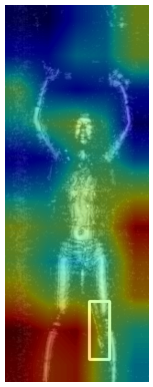

In [13]:
fv = avg_by_sum_least(pixels_information, all_fv_imgs)
figure(figsize=(10, 10), dpi=50)
plt.imshow(sample_img)
plt.imshow(fv, cmap="jet", alpha=0.5)
plt.axis('off');